### Initialize

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch
from networks import MLP
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
load_dir = '../output/no_offset_ddpg_0/'
obs_size = 8
action_size = 2

In [4]:
device = torch.device(0)
device

device(type='cuda', index=0)

### Get experience buffer

In [5]:
exp_buffer = torch.load('../output/no_offset_ddpg_0/exp_buffer.pt')
# entries are (s, a, r, s', done_flag) with |s|=8, |a|=2, |r|=1, |done_flag|=1

In [6]:
exp_buffer = torch.load(os.path.join(load_dir, "exp_buffer.pt"))
with open(os.path.join(load_dir, "exp_buffer_state.json"), "r") as fp:
    exp_buffer_state = json.load(fp)
    next_ind = exp_buffer_state["next_ind"]
    full = exp_buffer_state["full"]

In [7]:
exp_buffer

tensor([[0.0050, 1.4019, 0.5016,  ..., 0.0000, 0.0000, 0.0000],
        [0.0099, 1.3923, 0.5010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0149, 1.3821, 0.5010,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [8]:
# trim empty entries
exp_buffer = exp_buffer[:next_ind]
# randomly shuffle
exp_buffer = exp_buffer[torch.randperm(exp_buffer.size()[0])]

In [9]:
exp_buffer

tensor([[ 0.3869,  1.1788,  0.3290,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1589,  1.6129,  0.0713,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0361,  1.1771,  0.2183,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0586,  1.3612,  0.0031,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0238,  1.3730, -0.2434,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5080,  0.5027,  0.8730,  ...,  0.0000,  0.0000,  0.0000]])

### Make dataset by hallucinating offsets

In [10]:
num_samples = exp_buffer.size()[0]
num_samples

87085

In [11]:
state, action, reward, next_state, done_mask = torch.split(
    exp_buffer, [obs_size, action_size, 1, obs_size, 1],
    dim=1
)

In [12]:
offsets = torch.rand((num_samples,action_size)) - 0.5
print(torch.min(offsets), torch.max(offsets))
action.size(), offsets.size()

tensor(-0.5000) tensor(0.5000)


(torch.Size([87085, 2]), torch.Size([87085, 2]))

In [13]:
hallucinated_actions = action - offsets
Y = hallucinated_actions

In [14]:
hallucinated_buffer = torch.cat([state, hallucinated_actions, reward, next_state, done_mask], dim=1)
X = hallucinated_buffer

In [15]:
X.size(), Y.size()

(torch.Size([87085, 20]), torch.Size([87085, 2]))

### Make dataset splits

In [16]:
val_frac = 0.1
test_frac = 0.1
num_val = round(num_samples * val_frac)
num_test = round(num_samples * test_frac)
num_train = num_samples - num_val - num_test

X_train, X_val, X_test = torch.split(X, [num_train, num_val, num_test], dim=0)
Y_train, Y_val, Y_test = torch.split(Y, [num_train, num_val, num_test], dim=0)

In [17]:
print(X_train.size(), X_val.size(), X_test.size())
print(Y_train.size(), Y_val.size(), Y_test.size())

torch.Size([69669, 20]) torch.Size([8708, 20]) torch.Size([8708, 20])
torch.Size([69669, 2]) torch.Size([8708, 2]) torch.Size([8708, 2])


In [18]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [19]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

### Train MLP

In [24]:
model = MLP([20,64,32,2]).to(device)

In [25]:
epochs = 3
learning_rate = 1e-6
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
running_loss = 0.0
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f"epoch {epoch}")

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 0:    # every 1000 mini-batches...
            print(f'iter {i:6}  train loss: {running_loss/1000}')
            running_loss = 0.0
    
    running_val_loss = 0
    for i, data in enumerate(val_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

    val_loss = running_val_loss / num_val
    print(f"epoch {epoch} val loss: {val_loss}")

epoch 0
iter      0  train loss: 0.00029775527119636536
iter   1000  train loss: 0.16751520277932286
iter   2000  train loss: 0.026435363574419172
epoch 0 val loss: 0.00019501014804858142
epoch 1
iter      0  train loss: 0.0014859786496963351
iter   1000  train loss: 0.011875649232824798
iter   2000  train loss: 0.006705935888749082
epoch 1 val loss: 0.00012305220565378972
epoch 2
iter      0  train loss: 0.001359686040203087
iter   1000  train loss: 0.00433085054269759
iter   2000  train loss: 0.005180387807806255
epoch 2 val loss: 9.384635634498725e-05


In [27]:
# output model
output_path = 'output/sas_to_offset_MLP_0.pt'
torch.save(model, output_path)

In [32]:
loaded_model = torch.load(output_path).to(device)

In [33]:
loaded_model

MLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [34]:
Y_test[:10]

tensor([[-0.3422,  0.1250],
        [-0.2730, -0.0458],
        [-0.4096, -0.7725],
        [ 0.0558,  0.1071],
        [-0.3762, -0.3240],
        [ 0.5837,  0.7711],
        [-0.5749,  0.2857],
        [ 0.1882, -0.3445],
        [-0.2596,  0.1250],
        [ 0.2949, -0.4499]])

In [36]:
loaded_model(X_test[:10].to(device))

tensor([[-0.3758,  0.1252],
        [-0.2881, -0.0459],
        [-0.4266, -0.8181],
        [ 0.0541,  0.0807],
        [-0.4020, -0.2715],
        [ 0.5886,  0.7913],
        [-0.6347,  0.2941],
        [ 0.1943, -0.3928],
        [-0.2400,  0.1383],
        [ 0.3156, -0.4975]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
diffs = Y_test.to(device) - loaded_model(X_test.to(device))
diffs = diffs.detach().cpu()

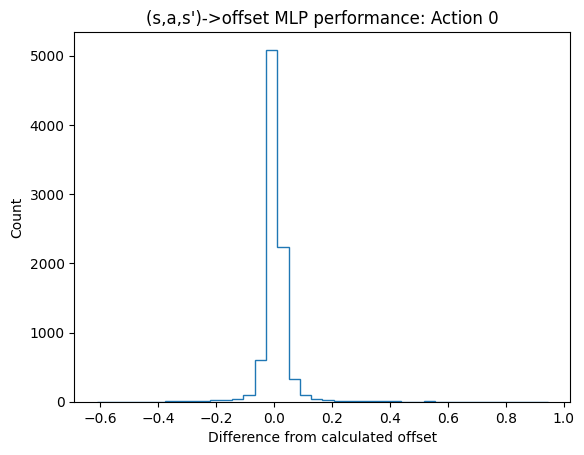

In [52]:
counts, bins = np.histogram(diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 0")
plt.show()

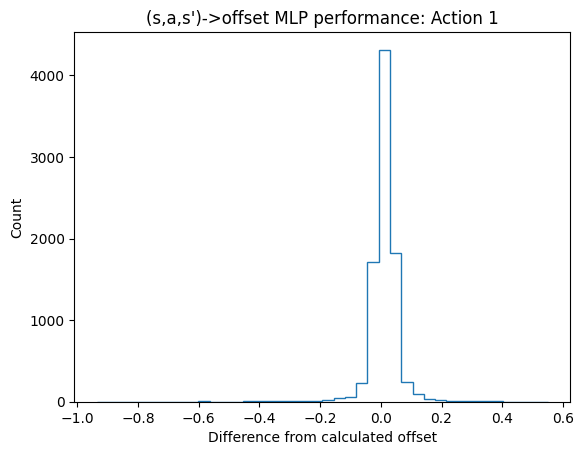

In [53]:
counts, bins = np.histogram(diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 1")
plt.show()